# 🗣️ Conversational RAG using Memory
<a target="_blank" href="https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/chat_with_rag.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" width="150" alt="Open In Colab"/>
</a>

In this notebook, we'll explore how to incorporate memory into a RAG pipeline to enable conversations with our documents, using an `InMemoryChatMessageStore`, a `ChatMessageRetriever`, and a `ChatMessageWriter`.

**Useful Sources**

* [📖 Docs](https://docs.haystack.deepset.ai/docs/intro)
* [📚 Tutorials](https://haystack.deepset.ai/tutorials)

>[💾 Chat with RAG](#scrollTo=UmuZmn1hN3NB)

>>[Installation](#scrollTo=1LRwBMJdF_d1)

>>[Enter OpenAI API key](#scrollTo=lJokyTRiPifH)

>>[Create DocumentStore and Index Documents](#scrollTo=avfIcgYlP5BE)

>>[Create Memory](#scrollTo=fYgmgJplan3h)

>>[Prompt Template for RAG with Memory](#scrollTo=lSOc2Ki1blUO)

>>[Prompt Template for Rephrasing User Query](#scrollTo=AoNwSoFIsdGf)

>>[Build the Pipeline](#scrollTo=tCOdSoAAQBb6)

>>>[Visualize the pipeline](#scrollTo=ba0EFLSfpwFE)

>>[Let's ask some questions 😀](#scrollTo=BmtRP897RgOc)



## Installation

Install Haystack, `haystack-experimental` and `datasets` with pip:

In [1]:
!pip install -U haystack-ai git+https://github.com/deepset-ai/haystack-experimental.git datasets

  Cloning https://github.com/deepset-ai/haystack-experimental.git to /tmp/pip-req-build-h5c41_de
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack-experimental.git /tmp/pip-req-build-h5c41_de
  Resolved https://github.com/deepset-ai/haystack-experimental.git to commit ab3fe0cc4a1ed7c281359ba11e6733fc6b7ae9b1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Enter OpenAI API key

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Create DocumentStore and Index Documents

Create an index with some example documents:

In [3]:
from haystack import Document
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=docs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


151

## Create Memory

Memory, so the conversation history, is saved as `ChatMessage` objects in a `InMemoryChatMessageStore`. When required, you can retrieve the conversation history from the chat message store using `ChatMessageRetriever`.

To store memory, initialize an `InMemoryChatMessageStore`, a `ChatMessageRetriever` and a `ChatMessageWriter`. Import these components from [`haystack-experimental`](https://github.com/deepset-ai/haystack-experimental) package:

In [4]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter

# Chat memory components
memory_store = InMemoryChatMessageStore()
memory_retriever = ChatMessageRetriever(memory_store)
memory_writer = ChatMessageWriter(memory_store)

## Prompt Template for RAG with Memory

Prepare a prompt template for RAG and additionally, add another section for memory. Memory info will be retrieved by `ChatMessageRetriever` from the `InMemoryChatMessageStore` and injected into the prompt through `memories` prompt variable.

In [5]:
from haystack.dataclasses import ChatMessage

system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.content }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""
user_message = ChatMessage.from_user(user_message_template)

## Prompt Template for Rephrasing User Query

In conversational systems, simply injecting memory into the prompt is not enough to perform RAG effectively. There needs to be a mechanism to rephrase the user's query based on the conversation history to ensure relevant documents are retrieved. For instance, if the first user query is "*What's the first name of Einstein?*" and the second query is "*Where was he born?*" the system should understand that "he" refers to Einstein. The rephrasing mechanism should then modify the second query to "*Where was Einstein born?*" to retrieve the correct documents.

Let's create a prompt that instructs the LLM to rephrase the user's query, incorporating the conversation history, to make it suitable for searching relevant documents.

In [6]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.content }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

## Build the Pipeline

Add components for query rephrasing, RAG and memory to build your chat pipeline. Incorporate [BranchJoiner](https://docs.haystack.deepset.ai/docs/branchjoiner) into your pipeline to handle messages from both the user and the LLM, writing them to the memory store.

In [7]:
from typing import List
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators import OpenAIGenerator
from haystack.components.joiners import BranchJoiner
from haystack.components.converters import OutputAdapter

pipeline = Pipeline()

# components for query rephrasing
pipeline.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
pipeline.add_component("query_rephrase_llm", OpenAIGenerator())
# convert the output of `OpenAIGenerator` into the input of `InMemoryBM25Retriever`
pipeline.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))

# components for RAG
pipeline.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
pipeline.add_component("llm", OpenAIChatGenerator())

# components for memory
pipeline.add_component("memory_retriever", memory_retriever)
pipeline.add_component("memory_writer", memory_writer)
pipeline.add_component("memory_joiner", BranchJoiner(List[ChatMessage]))

# connections for query rephrasing
pipeline.connect("memory_retriever", "query_rephrase_prompt_builder.memories")
pipeline.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
pipeline.connect("query_rephrase_llm.replies", "list_to_str_adapter")
pipeline.connect("list_to_str_adapter", "retriever.query")

# connections for RAG
pipeline.connect("retriever.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.messages")
pipeline.connect("llm.replies", "memory_joiner")

# connections for memory
pipeline.connect("memory_joiner", "memory_writer")
pipeline.connect("memory_retriever", "prompt_builder.memories")

🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: BranchJoiner
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> retriever.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.value (List[ChatMessage])
  - memory_retriever.messages -> query_rephrase_prompt_builder.memories (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.value -> memory_writer.messages (List[ChatMes

### Visualize the pipeline

Visualize the pipeline with the [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to confirm the connections are correct.

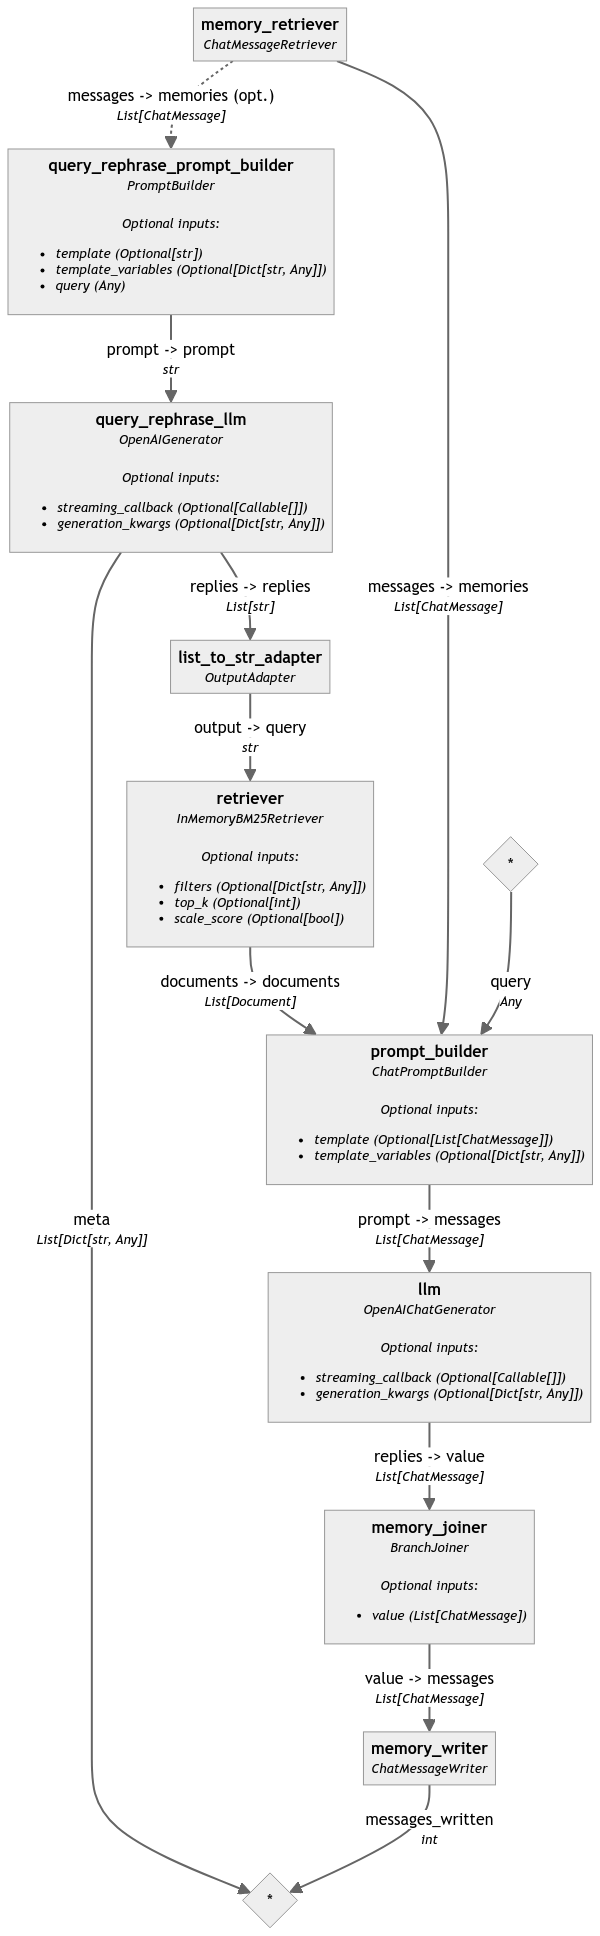

In [8]:
pipeline.show()

## Let's ask some questions 😀

Now, run the pipeline with the relevant inputs. Instead of sending the query directly to the `retriever`, first pass it to the `query_rephrase_prompt_builder` to rephrase it. Ensure that every user query is also sent to the `memory_joiner` so that both the user queries and the LLM responses are stored together in the memory store.

Here are some example queries and follow ups you can try:

* *What does Rhodes Statue look like?* - *Who built it?* - *Did he destroy it?*
* *Where is Gardens of Babylon?* - *When was it built?*

In [9]:
while True:
    messages = [system_message, user_message]
    question = input("Enter your question or Q to exit.\n🧑 ")
    if question=="Q":
        break

    res = pipeline.run(data={"query_rephrase_prompt_builder": {"query": question},
                             "prompt_builder": {"template": messages, "query": question},
                             "memory_joiner": {"value": [ChatMessage.from_user(question)]}},
                            include_outputs_from=["llm","query_rephrase_llm"])
    search_query = res['query_rephrase_llm']['replies'][0]
    print(f"   🔎 Search Query: {search_query}")
    assistant_resp = res['llm']['replies'][0]
    print(f"🤖 {assistant_resp.content}")

Enter your question or Q to exit.
🧑 What does Rhodes Statue look like?
   🔎 Search Query: What does the Rhodes Statue look like?
🤖 While scholars do not have a definitive description of the entire Rhodes Statue, it is believed that the head would have had curly hair with evenly spaced spikes of bronze or silver flame radiating, similar to the imagery found on contemporary Rhodian coins. The statue was planned to be a colossal bronze statue of their patron god, Helios, under the direction of Chares, a native of Lindos in Rhodes. The actual appearance beyond the head details is uncertain.
Enter your question or Q to exit.
🧑 Who built it? 
   🔎 Search Query: Who built the Rhodes Statue?
🤖 The Colossus of Rhodes was built by Chares of Lindos in 280 BC.
Enter your question or Q to exit.
🧑 Did he destroy it?
   🔎 Search Query: Did Chares of Lindos destroy the Colossus of Rhodes?
🤖 According to the provided information, the Colossus of Rhodes was destroyed during an earthquake in 226 BC. Late